## Лабораторна робота 4

### Завдання 1:
#### Розробити власну архітектуру GAN для датасету fashion mnist  для побудови реалістичного зображення певного типу одягу, наприклад, штанів, футболки, сукні.
#### Необхідно завантажити датасет, вивести типи одягу, що містить датасет. 
Підготувати дані, підібрати кількість шарів, функції активації і тд 
Побудувати графік функції втрат, вивести значення функції втрат. Вивести результат.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

Типи одягу у датасеті:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
(5984, 28, 28) (5984,)
1/50: ===========: tf.Tensor(1.1215416, shape=(), dtype=float32)
Час епохи 1 складає 27.41991686820984 секунд
2/50: ===========: tf.Tensor(1.0283414, shape=(), dtype=float32)
Час епохи 2 складає 29.430811643600464 секунд
3/50: ===========: tf.Tensor(0.73712003, shape=(), dtype=float32)
Час епохи 3 складає 24.73087477684021 секунд
4/50: ===========: tf.Tensor(0.76598036, shape=(), dtype=float32)
Час епохи 4 складає 29.521841526031494 секунд
5/50: ===========: tf.Tensor(0.71869916, shape=(), dtype=float32)
Час епохи 5 складає 25.17392325401306 секунд
6/50: ===========: tf.Tensor(0.7297533, shape=(), dtype=float32)
Час епохи 6 складає 24.785983085632324 секунд
7/50: ===========: tf.Tensor(0.7635361, shape=(), dtype=float32)
Час епохи 7 складає 23.69802498817444 секунд
8/50: ===========: tf.Tensor(0.7812213, shape=(), dtype=float32)
Час епо

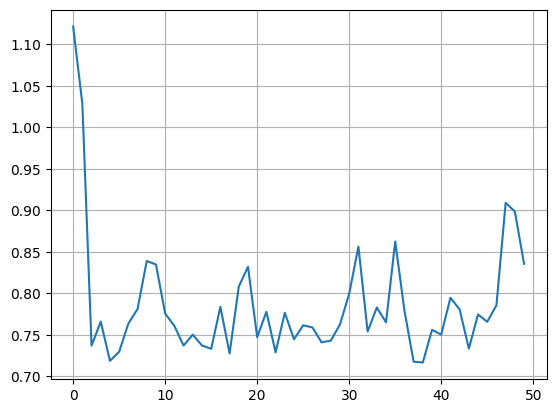

1/1 [==============================] - 0s 21ms/step


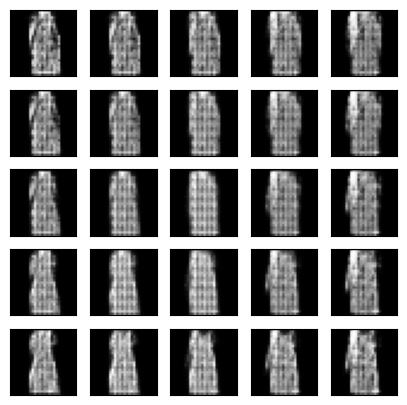

In [2]:
# Завантаження датасету
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Виведення типів одягу, що містить датасет
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("Типи одягу у датасеті:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

# Відбір лише певного типу одягу (наприклад, футболок)
x_train = x_train[y_train == 3]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

# Стандартизація вхідних даних
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Формування мереж
hidden_dim = 2


def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())


# Генератор
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

# Дискримінатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

# Втрати
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Навчання
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Час епохи {} складає {} секунд'.format(epoch, time.time() - start))

  return history


# Запуск процеса навчання
EPOCHS = 50
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

# Відображення результатів генерації
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Завдання 2:
#### Намалювати крижинку Коха з можливістю вибору рівня рекурсії.

In [4]:
import turtle

class LSystem2D:
    def generate_path(self, n_iter):
        for n in range(n_iter):
            new_state = ''
            for char in self.state:
                if char in self.rules:
                    new_state += self.rules[char]
                else:
                    new_state += char
            self.state = new_state

    def __init__(self, t, axiom, width, length, angle, rules=None):
        self.axiom = axiom      # ініціатор
        self.state = axiom      # рядок з набором команд для фракталу (на початку він є ініціатором)
        self.width = width      # Товщина лінії креслення
        self.length = length    # Довжина одного прямого відрізка кривої
        self.angle = angle      # Фіксований кут повороту
        self.t = t              # Сама черепаха
        self.t.pensize(self.width)
        if rules is None:
            rules = {}
        self.rules = rules

    def draw_turtle(self, start_pos, start_angle):
        turtle.tracer(1, 0)  # Режим форсажу для черепахи
        self.t.up()  # Черепаха ширяє над поверхнею (щоб не залишилося і сліду)
        self.t.setpos(start_pos)  # Початкове вихідне положення
        self.t.seth(start_angle)  # Початковий кут повороту
        self.t.down()  # Черепаха спускається

        for move in self.state:
            if move == 'F':
                self.t.forward(self.length)
            elif move == '+':
                self.t.left(self.angle)
            elif move == '-':
                self.t.right(self.angle)

        turtle.done()  # щоб вікно не закривалося після малювання

width = 2400
height = 600
screen = turtle.Screen()
screen.setup(width, height, 0, 0)

t = turtle.Turtle()
t.ht()  # Приховування черепахи

pen_width = 2  # Товщина лінії креслення (у пікселях)
f_len = 15  # Довжина одного відрізка прямої лінії (у пікселях)
angle = 60  # Фіксований кут повороту (у градусах)

rules = {
    'F': 'F+F--F+F'
}

l_sys = LSystem2D(t, "F+F--F+F", pen_width, f_len, angle, rules)
level = int(input("Введіть рівень рекурсії: "))

l_sys.generate_path(level)
l_sys.draw_turtle((0, 0), 0)

Введіть рівень рекурсії:  2


### Завдання 3:
#### Намалювати килим Серпинського.

In [1]:
import turtle

class LSystem2D:
    def __init__(self, t, axiom, width, length, angle):
        self.axiom = axiom      # ініціатор
        self.state = axiom      # рядок з набором команд для фракталу (на початку він є ініціатором)
        self.width = width      # Товщина лінії креслення
        self.length = length    # Довжина одного прямого відрізка кривої
        self.angle = angle      # Фіксований кут повороту
        self.t = t              # Сама черепаха
        self.t.pensize(self.width)
        self.rules = {}         # Правила заміни символів

    def add_rules(self, *rules):
        for key, value in rules:
            self.rules[key] = value

    def generate_path(self, n_iter):
        for n in range(n_iter):
            for key, value in self.rules.items():
                self.state = self.state.replace(key, value.lower())

            self.state = self.state.upper()

    def draw_turtle(self, start_pos, start_angle):
        # ***********
        turtle.tracer(1, 0)     # Режим форсажу для черепахи
        self.t.up()             # Черепаха ширяє над поверхнею (щоб не залишилося і сліду)
        self.t.setpos(start_pos)    # Початкове вихідне положення
        self.t.seth(start_angle)    # Початковий кут повороту
        self.t.down()               # Черепаха спускається 

        for move in self.state:
            if move == 'F':
                self.t.forward(self.length)
            elif move == '+':
                self.t.left(self.angle)
            elif move == '-':
                self.t.right(self.angle)

        turtle.done()        # щоб вікно не закривалося після малювання

# ********** щоб вікно з'явилося у верхньому лівому куті з розмірами 1200x600
width = 2400
height = 1200
screen = turtle.Screen()
screen.setup(width, height, 0, 0)
# **********

t = turtle.Turtle()
t.ht()          # Приховування черепахи

pen_width = 2   # Товщина лінії креслення (у пікселях)
f_len = 15      # Довжина одного відрізка прямої лінії (у пікселях)
angle = 60      # Фіксований кут
axiom = "FXF--FF--FF"

level = int(input("Введіть рівень рекурсії: "))
l_sys = LSystem2D(t, axiom, pen_width, f_len, angle)
l_sys.add_rules(("F", "FF"), ("X", "--FXF++FXF++FXF--"))
l_sys.generate_path(level)
l_sys.draw_turtle((0, 0), 0)

Введіть рівень рекурсії:  5


Висновок: Отже, на лабораторній роботі я навчилася розробляти архітектуру GAN та будувати реалістичні зображення. Також я спробувала у створенні фракталів, насамперед дослідила малювання крижинки Коха та килима Серпинського.